In [22]:
%load_ext autoreload
%autoreload 2

In [71]:
!git clone https://github.com/TheoBertrand-Dauphine/MVA_NT_geodesic_methods

# %cd MVA_NT_geodesic_methods

Cloning into 'MVA_NT_geodesic_methods'...


In [72]:
import MVA_NT_geodesic_methods.nt_toolbox.grad as toolgrad
import MVA_NT_geodesic_methods.nt_toolbox.div as tooldiv

# from nt_toolbox.general import *
# from nt_toolbox.signal import *

In [ ]:
!gdown --fuzzy 'https://drive.google.com/file/d/15GedlUNuP57IisUftw-iywgCdI8hMcNA/view?usp=sharing' -O '__data'

In [48]:
import pydicom as dicom
import torch
from torch.utils.data import DataLoader, random_split
import os 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import ndimage


from models import LayerFCN8
from datasets import save_multilayer_label_map, CHAOSDataset

root_dir = os.path.dirname(os.getcwd())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device :', device)

device : cpu


## Visualize generated layer label map

In [5]:
data_folder = os.path.join(root_dir, '__data', 'Train_Sets', 'CT')

In [ ]:
from datasets import save_multilayer_label_map

save_multilayer_label_map(data_folder)

c:\Users\INES\Documents\3A_MVA\DeformableModelsGeodesics\active_contour_cnn\src
91
Img id  5
Input image shape (512, 512) min 0 max 2285
Label size : (512, 512); type float64; min : 0.0; max : 1.0; mean : 0.027873992919921875
pixel spacing [0.791015625, 0.791015625]
Img id  60
Input image shape (512, 512) min 0 max 2189
Label size : (512, 512); type float64; min : 0.0; max : 1.0; mean : 0.051792144775390625
pixel spacing [0.791015625, 0.791015625]


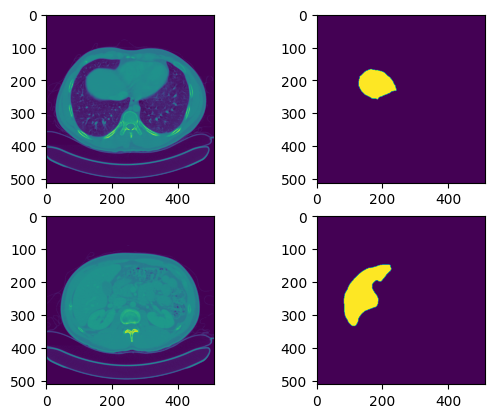

In [13]:
patient_id = 0
a=300
for i, patient_id in enumerate([3, 5]):
    img_id = [5, 60]
    files = sorted(os.listdir(data_folder))

    dicom_files = sorted(os.listdir(f"{data_folder}/{files[patient_id]}/DICOM_anon"))
    ground_files = sorted(os.listdir(f"{data_folder}/{files[patient_id]}/Ground"))
    print(len(dicom_files))
    ds0 = dicom.dcmread(os.path.join(data_folder, files[patient_id], 'DICOM_anon', dicom_files[img_id[0]]))
    label_map0 = Image.open(os.path.join(data_folder, files[patient_id], 'Ground', ground_files[img_id[0]]))
    label_map0 = np.array(label_map0).astype(float)
    print("Img id ", img_id[0])
    print('Input image shape', ds0.pixel_array.shape, 'min', ds0.pixel_array.min(), 'max', ds0.pixel_array.max())
    print(f"Label size : {label_map0.shape}; type {label_map0.dtype}; min : {label_map0.min()}; max : {label_map0.max()}; mean : {label_map0.mean()}")
    print('pixel spacing', ds0.PixelSpacing)

    ds1 = dicom.dcmread(os.path.join(data_folder, files[patient_id], 'DICOM_anon', dicom_files[img_id[1]]))
    label_map1 = Image.open(os.path.join(data_folder, files[patient_id], 'Ground', ground_files[img_id[1]]))
    label_map1 = np.array(label_map1).astype(float)
    print("Img id ", img_id[1])
    print('Input image shape', ds1.pixel_array.shape, 'min', ds1.pixel_array.min(), 'max', ds1.pixel_array.max())
    print(f"Label size : {label_map1.shape}; type {label_map1.dtype}; min : {label_map1.min()}; max : {label_map1.max()}; mean : {label_map1.mean()}")
    print('pixel spacing', ds1.PixelSpacing)

    # img0 = ( ds0.pixel_array - ds0.pixel_array.min()) / (ds0.pixel_array.max() - ds0.pixel_array.min())
    # img1 = ( ds1.pixel_array - ds1.pixel_array.min()) / (ds1.pixel_array.max() - ds1.pixel_array.min())

    fig = plt.figure()
    fig.add_subplot(2, 2, 1)
    plt.imshow(ds0.pixel_array) # , cmap='gray'
    fig.add_subplot(2, 2, 2)
    plt.imshow(label_map0)

    fig.add_subplot(2, 2, 3)
    plt.imshow(ds1.pixel_array)
    fig.add_subplot(2, 2, 4)
    plt.imshow(label_map1)

    plt.show()
    break

Distance to background : min : -45.17742799230607; max : 406.06034034364893


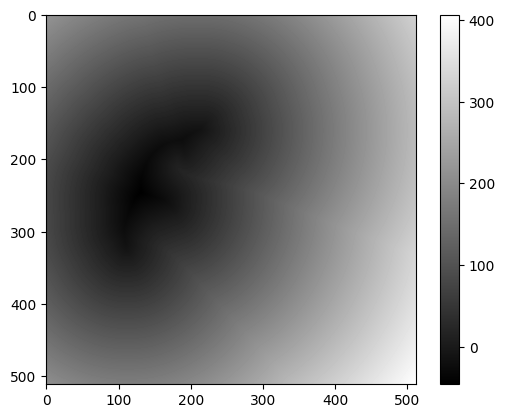

In [63]:
signed_dist = ndimage.distance_transform_edt(1 - label_map1) - ndimage.distance_transform_edt(label_map1) 
print(f"Distance to background : min : {signed_dist.min()}; max : {signed_dist.max()}")

plt.imshow(signed_dist, cmap='gray')
plt.colorbar()

plt.show()


Delta : 2.528395061728395
Label -2 size : 1281
Label -1 size : 1170
Label 0 size : 1424
Label 1 size : 1233
Label 2 size : 1431


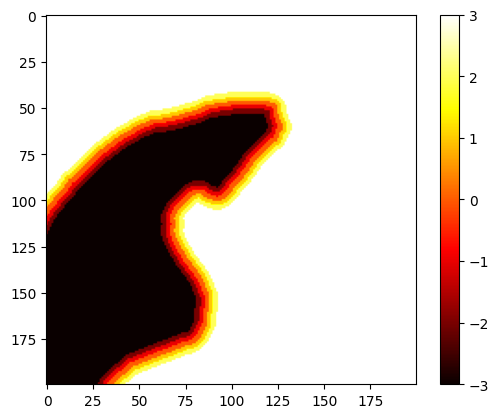

In [77]:
d = 2
delta = d / ds1.PixelSpacing[0]
print(f"Delta : {delta}")
N = 4
layer_label_map = np.zeros_like(label_map1)
layer_label_map[ signed_dist <= (- N+2 - 0.5)*delta] = -N+1
layer_label_map[ signed_dist > (N - 1.5)*delta] = N-1
a = 1.4
for i in range(-N+2, N-1):
    if i==0:
        cond = ((i-0.5)*(delta*a) < signed_dist) & (signed_dist <= (i+0.5)*(delta*a))
    elif i==-1:
        cond = ((i-0.5)*delta < signed_dist) & (signed_dist <= (i+0.5)*(a*delta))
    elif i==1:
        cond = ((i-0.5)*(delta*a) < signed_dist) & (signed_dist <= (i+0.5)*delta)
    else :
        cond = ((i-0.5)*delta < signed_dist) & (signed_dist <= (i+0.5)*delta)
    layer_label_map[cond] = i
    print(f'Label {i} size : {np.sum(cond)}')


fig = plt.figure()
plt.imshow(layer_label_map[100:300, 100:300], cmap='hot')
plt.colorbar()
plt.show()

(512, 512)


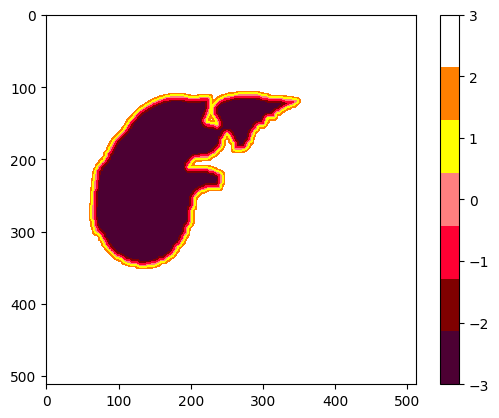

In [8]:
from matplotlib.colors import LinearSegmentedColormap

layer_label_map = np.load(os.path.join(data_folder, '8', 'Layer_label_map', 'GT_map_050.npy'))
print(layer_label_map.shape)

colors = [(0.3, 0, 0.2), (0.5, 0, 0), (1, 0, 0.2), (1, 0.5, 0.5), (1, 1, 0), (1, .5, 0), (1, 1, 1)] #  (.5, .5, 1),
cmap_name = 'my_list'
n_bin = 7

cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)

fig, ax = plt.subplots()
im = ax.imshow(layer_label_map, cmap=cmap)

fig.colorbar(im, ax=ax)

plt.show()

## Get familiar with convolutions

In [6]:
# inp = torch.randn(1, 16, 12, 12)

# downsample = torch.nn.Conv2d(16, 16, 3, stride=2, padding=0)
# upsample = torch.nn.ConvTranspose2d(16, 16, 3, stride=2, padding=0)

# out = downsample(inp)
# print(out.shape)
# out = upsample(out)
# print(out.shape)

c:\Users\INES\Documents\3A_MVA\DeformableModelsGeodesics\active_contour_cnn/__data/Train_Sets/CT
img torch.Size([512, 512])


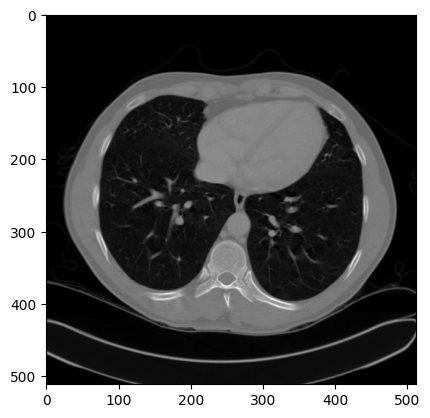

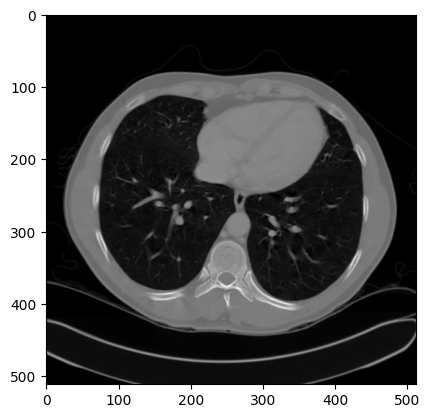

In [14]:
data_folder = root_dir + '/__data/Train_Sets/CT'
print(data_folder)

patient = 8
dicom_files = os.listdir(f"{data_folder}/{patient}/DICOM_anon/")
with open(f"{data_folder}/{patient}/DICOM_anon/{dicom_files[0]}", 'rb') as file:
    ds = dicom.dcmread(file)

img = torch.tensor(ds.pixel_array.astype(np.float32))
img = (img - img.min()) / (img.max() - img.min())
print('img', img.shape)
plt.imshow(img, cmap='gray')
plt.show()

# .view(1, *img.shape)
imgRGB = img.expand(3, -1, -1).contiguous() # expand better for memory than repeat
plt.imshow(imgRGB.permute(1, 2, 0))
plt.show()

In [26]:
data = CHAOSDataset(data_folder)

In [27]:
nb_data = len(data)
print(nb_data)

2066


In [29]:
i = np.random.randint(0, nb_data)
inp, target = data[i]
print('inp', inp.shape)
print('target', target.shape)

inp torch.Size([3, 512, 512])
target (512, 512)


In [37]:
target = torch.tensor(target + target.max() + 1, dtype=torch.float32)

In [38]:
torch.unique(target)

tensor([1., 2., 3., 4., 5., 6., 7.])

## Train FCN

In [59]:
dataset = CHAOSDataset(data_folder)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.9, 0.05, .05])

print(f'Nb train data : {len(train_dataset)}\n'
      f'Nb val data : {len(val_dataset)}\n'
      f'Nb test data : {len(test_dataset)}\n')


Nb train data : 1860
Nb val data : 103
Nb test data : 103



In [61]:
t, lab = dataset[0]
lab.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [67]:
class EarlyStopping:
    def __init__(self, patience:int=5, min_delta:float = 1e-3):
        self.patience = patience
        self.min_delta = min_delta
        self.prev_loss = None
        self.counter = 0

    def __call__(self, val_loss : float):
        
        if self.prev_loss is None:
            self.prev_loss = val_loss
            return False
        
        if np.abs(self.prev_loss - val_loss) < self.min_delta:
            self.counter += 1
        else:
            self.counter = 0
        
        self.prev_loss = val_loss

        if self.counter >= self.patience:
            return True
        
        return False


In [68]:
def train(model : torch.nn.Module, optimizer : torch.optim, 
          train_dataloader : DataLoader, val_dataloader : DataLoader,
          lr_scheduler : torch.optim.lr_scheduler = None,
          early_stopper : EarlyStopping = None,
          nepochs_max:int=100):
    
    criterion = torch.nn.CrossEntropyLoss()
    train_loss, val_loss = [], []
    
    for epoch in range(nepochs_max):
        bs_train_loss = 0
        bs_val_loss = 0
        train_bs, val_bs = 0, 0
        model.train()

        for (inp, target) in train_dataloader:
            inp = inp.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(inp)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            bs_train_loss += loss.item()
            train_bs += 1

        train_loss.append(bs_train_loss / train_bs)


        with torch.no_grad():
            model.eval()
            for (inp, target) in val_dataloader:
                output = model(inp)
                loss = criterion(output, target)
                bs_val_loss += loss.item()
                val_bs += 1

            val_loss.append(bs_val_loss / val_bs)

        if lr_scheduler is not None:
            lr_scheduler.step()

        if (epoch+1) % 1 == 0:
            print(f'Epoch {epoch} : train loss {train_loss[-1]}; val loss {val_loss[-1]}')

        if early_stopper is not None:
            if early_stopper(val_loss[-1]):
                print(f'Early stopping at epoch {epoch}')
                break

    return train_loss, val_loss 

def compute_test_loss(model, test_dataloader):
    criterion = torch.nn.CrossEntropyLoss()
    test_loss = 0
    test_bs = 0
    model.eval()
    with torch.no_grad():
        for (inp, target) in test_dataloader:
            output = model(inp)
            loss = criterion(output, target)
            test_loss += loss.item()
            test_bs += 1

    return test_loss / test_bs

def plot_learning_curves(train_loss, val_loss):
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [69]:
batch_size = 2
lr = 0.00005
momentum = 0.9
nepochs = 10

modelFCN = LayerFCN8(7, path_to_pretrained_folder=os.path.join(root_dir, '__results'))
# freeze pretrained layers
for name, param in modelFCN.named_parameters():
    if 'score' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.SGD(modelFCN.parameters(), lr=lr, momentum=momentum)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs, eta_min=0.00001)
early_stopper = EarlyStopping(patience=5, min_delta=1e-3)



conv1_1.weight
conv1_1.bias
conv1_2.weight
conv1_2.bias
conv2_1.weight
conv2_1.bias
conv2_2.weight
conv2_2.bias
conv3_1.weight
conv3_1.bias
conv3_2.weight
conv3_2.bias
conv3_3.weight
conv3_3.bias
conv4_1.weight
conv4_1.bias
conv4_2.weight
conv4_2.bias
conv4_3.weight
conv4_3.bias
conv5_1.weight
conv5_1.bias
conv5_2.weight
conv5_2.bias
conv5_3.weight
conv5_3.bias
fc6.weight
fc6.bias
fc7.weight
fc7.bias
score_fr.weight torch.Size([7, 4096, 1, 1])
score_fr.bias torch.Size([7])
score_pool3.weight torch.Size([7, 256, 1, 1])
score_pool3.bias torch.Size([7])
score_pool4.weight torch.Size([7, 512, 1, 1])
score_pool4.bias torch.Size([7])
upscore2.weight torch.Size([7, 7, 4, 4])
upscore8.weight torch.Size([7, 7, 16, 16])
upscore_pool4.weight torch.Size([7, 7, 4, 4])


In [70]:
train_loss, val_loss = train(modelFCN, optimizer,
                             train_loader, val_loader,
                             nepochs_max=nepochs, 
                             lr_scheduler=None,
                             early_stopper=None)
plot_learning_curves(train_loss, val_loss)

KeyboardInterrupt: 

In [ ]:
test_loss = compute_test_loss(modelFCN, test_loader)
print(f'Test loss of trained model : {test_loss}')

In [ ]:
modelFCN.conv2_1.weight.requires_grad